In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [3]:
#hide
from fastbook import *

# Other Computer Vision Problems

## Multi-Label Classification

### The Data

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Sidebar: Pandas and DataFrames

In [5]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: str

In [6]:
df.iloc[0,:]
# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [7]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: str

In [8]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [9]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


### End sidebar

### Constructing a DataBlock

In [10]:
dblock = DataBlock()

In [11]:
dsets = dblock.datasets(df)

In [12]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [13]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [14]:
x['fname']

'008663.jpg'

In [15]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [16]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [17]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/Users/explorer/.fastai/data/pascal_2007/train/002844.jpg'), ['train'])

In [18]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [27]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

['dog']

In [28]:
ImageBlock??

Signature: ImageBlock(cls: 'PILBase' = <class 'fastai.vision.core.PILImage'>)
Source:   
def ImageBlock(cls:PILBase=PILImage):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)
File:      /opt/homebrew/Caskroom/miniconda/base/envs/fastai-mps/lib/python3.11/site-packages/fastai/vision/data.py
Type:      function

In [29]:
MultiCategoryBlock??

Signature:
MultiCategoryBlock(
    encoded: 'bool' = False,
    vocab: 'MutableSequence | pd.Series' = None,
    add_na: 'bool' = False,
)
Source:   
def MultiCategoryBlock(
    encoded:bool=False, # Whether the data comes in one-hot encoded
    vocab:MutableSequence|pd.Series=None, # List of unique class names 
    add_na:bool=False, # Add `#na#` to `vocab`
):
    "`TransformBlock` for multi-label categorical targets"
    tfm = EncodedMultiCategorize(vocab=vocab) if encoded else [MultiCategorize(vocab=vocab, add_na=add_na), OneHotEncode]
    return TransformBlock(type_tfms=tfm)
File:      /opt/homebrew/Caskroom/miniconda/base/envs/fastai-mps/lib/python3.11/site-packages/fastai/data/block.py
Type:      function

In [30]:
L??

Init signature: L(items=None, *rest, use_list=False, match=None)
Source:        
class L(GetAttr, CollBase, metaclass=_L_Meta):
    "Behaves like a list of `items` but can also index with list of indices or masks"
    _default='items'
    def __init__(self, items=None, *rest, use_list=False, match=None):
        if (use_list is not None) or not is_array(items):
            items = listify(items, *rest, use_list=use_list, match=match)
        super().__init__(items)

    @property
    def _xtra(self): return None
    def _new(self, items, *args, **kwargs): return type(self)(items, *args, use_list=None, **kwargs)
    def __getitem__(self, idx):
        "Retrieve `idx` (can be list of indices, or mask, or int) items"
        if isinstance(idx,int) and not hasattr(self.items,'iloc'): return self.items[idx]
        return self._get(idx) if is_indexer(idx) else L(self._get(idx), use_list=None)

    def _get(self, i):
        if is_indexer(i) or isinstance(i,slice): return getattr(self.items,

In [31]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [32]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

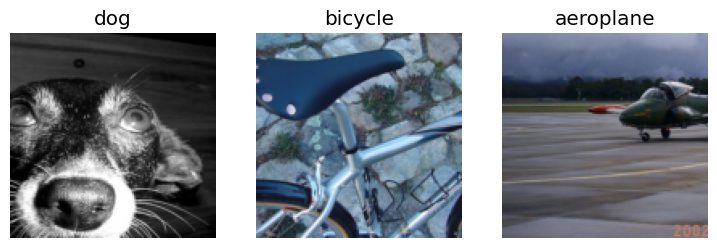

In [33]:
dls.show_batch(nrows=1, ncols=3)

### Binary Cross-Entropy

In [34]:
learn = vision_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/explorer/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:09<00:00, 4.92MB/s]


In [35]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [36]:
activs[0]

TensorImage([-1.4608,  0.9895,  0.5279, -1.0224, -1.4174, -0.1778, -0.4821, -0.2561,  0.6638,  0.1715,  2.3625,  4.2209,  1.0515,  4.5342,  0.5485,  1.0585, -0.7960,  2.2771, -1.9935,  1.9645],
            grad_fn=<AliasBackward0>)

In [37]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [41]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(TensorBase(activs), TensorBase(y))
loss

TensorBase(1.0524, grad_fn=<AliasBackward0>)

In [39]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [40]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [42]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
with learn.no_bar():
    learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/explorer/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:13<00:00, 7.74MB/s]


[0, 0.9532376527786255, 0.7116315960884094, 0.2272111475467682, '00:35']
[1, 0.8306196331977844, 0.5528769493103027, 0.2749004364013672, '00:31']
[2, 0.6072499752044678, 0.19196519255638123, 0.8265539407730103, '00:31']
[3, 0.36032718420028687, 0.11421898007392883, 0.9470915198326111, '00:31']
[0, 0.1242140457034111, 0.10374277085065842, 0.950657308101654, '00:37']
[1, 0.11276735365390778, 0.09780772030353546, 0.9571713209152222, '00:38']
[2, 0.09658779203891754, 0.09499561041593552, 0.9566534757614136, '00:43']


In [43]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

[0.09499561041593552, 0.9356574416160583]

In [44]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

[0.09499561041593552, 0.9430079460144043]

In [45]:
preds,targs = learn.get_preds()

In [46]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9590)

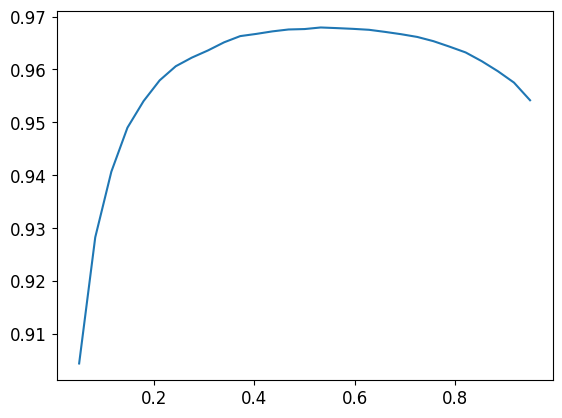

In [47]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

## Regression

### Assemble the Data

In [4]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [5]:
#hide
Path.BASE_PATH = path

In [6]:
path.ls().sorted()

[Path('.DS_Store'), Path('01'), Path('01.obj'), Path('02'), Path('02.obj'), Path('03'), Path('03.obj'), Path('04'), Path('04.obj'), Path('05'), Path('05.obj'), Path('06'), Path('06.obj'), Path('07'), Path('07.obj'), Path('08'), Path('08.obj'), Path('09'), Path('09.obj'), Path('10'), Path('10.obj'), Path('11'), Path('11.obj'), Path('12'), Path('12.obj'), Path('13'), Path('13.obj'), Path('14'), Path('14.obj'), Path('15'), Path('15.obj'), Path('16'), Path('16.obj'), Path('17'), Path('17.obj'), Path('18'), Path('18.obj'), Path('19'), Path('19.obj'), Path('20'), Path('20.obj'), Path('21'), Path('21.obj'), Path('22'), Path('22.obj'), Path('23'), Path('23.obj'), Path('24'), Path('24.obj'), Path('io_sample.cpp'), Path('readme.txt')]

In [7]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'), Path('01/frame_00003_pose.txt'), Path('01/frame_00003_rgb.jpg'), Path('01/frame_00004_pose.txt'), Path('01/frame_00004_rgb.jpg'), Path('01/frame_00005_pose.txt'), Path('01/frame_00005_rgb.jpg'), Path('01/frame_00006_pose.txt'), Path('01/frame_00006_rgb.jpg'), Path('01/frame_00007_pose.txt'), Path('01/frame_00007_rgb.jpg'), Path('01/frame_00008_pose.txt'), Path('01/frame_00008_rgb.jpg'), Path('01/frame_00009_pose.txt'), Path('01/frame_00009_rgb.jpg'), Path('01/frame_00010_pose.txt'), Path('01/frame_00010_rgb.jpg'), Path('01/frame_00011_pose.txt'), Path('01/frame_00011_rgb.jpg'), Path('01/frame_00012_pose.txt'), Path('01/frame_00012_rgb.jpg'), Path('01/frame_00013_pose.txt'), Path('01/frame_00013_rgb.jpg'), Path('01/frame_00014_pose.txt'), Path('01/frame_00014_rgb.jpg'), Path('01/frame_00015_pose.txt'), Path('01/frame_00015_rgb.jpg'), Path('01/frame_00016_pose.txt'), Path('01/frame_00016_rgb.jpg'), Path('01/frame_00017_pose.txt'), Path('01/frame_00017_rgb.j

In [8]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('03/frame_00393_pose.txt')

In [9]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

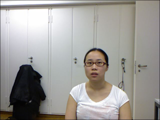

In [10]:
im.to_thumb(160)

In [11]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [12]:
get_ctr(img_files[0])

tensor([387.1024, 261.9126])

In [13]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=aug_transforms(size=(240,320)), 
)

/opt/homebrew/Caskroom/miniconda/base/envs/fastai-mps/lib/python3.11/site-packages/torch/_tensor.py:1512: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  ret = func(*args, **kwargs)


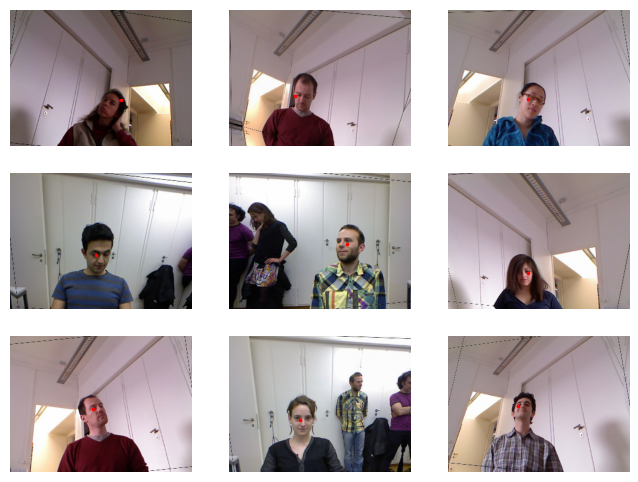

In [14]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [15]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [16]:
yb[0]

TensorPoint([[-0.1672, -0.0933]], device='mps:0')

### Training a Model

In [32]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

In [33]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

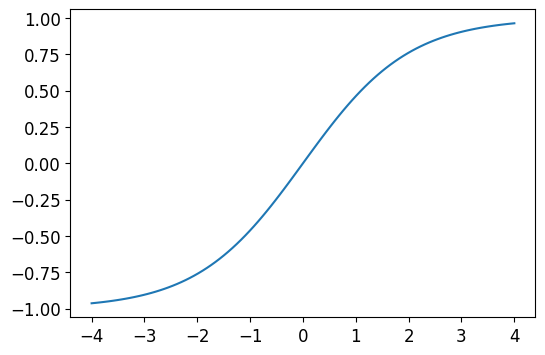

In [34]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [35]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.005248074419796467)

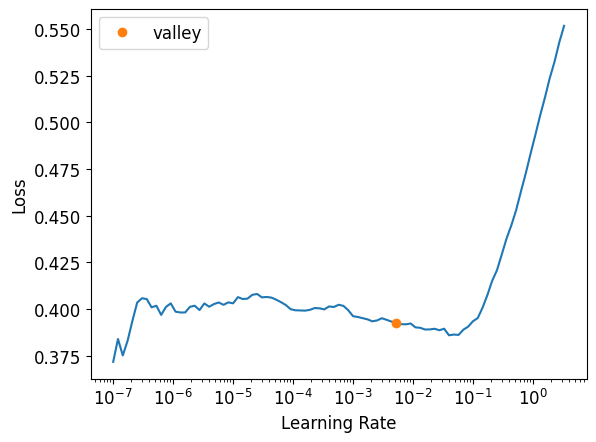

In [21]:
learn.lr_find()

In [36]:
"mps" if torch.backends.mps.is_available() else "cpu"

'mps'

In [37]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.050901,0.006093,03:03


epoch,train_loss,valid_loss,time
0,0.009568,0.002446,04:08
1,0.003158,0.001088,04:36


KeyboardInterrupt: 

In [24]:
math.sqrt(0.0001)

0.01

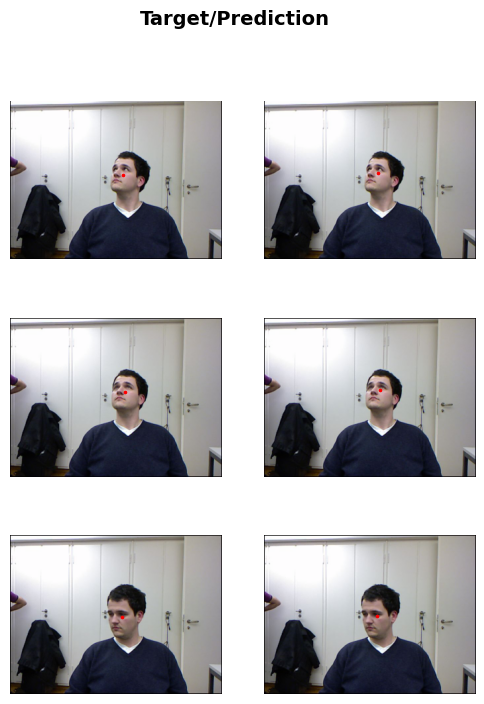

In [25]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

## Conclusion

## Questionnaire

1. How could multi-label classification improve the usability of the bear classifier?
1. How do we encode the dependent variable in a multi-label classification problem?
1. How do you access the rows and columns of a DataFrame as if it was a matrix?
1. How do you get a column by name from a DataFrame?
1. What is the difference between a `Dataset` and `DataLoader`?
1. What does a `Datasets` object normally contain?
1. What does a `DataLoaders` object normally contain?
1. What does `lambda` do in Python?
1. What are the methods to customize how the independent and dependent variables are created with the data block API?
1. Why is softmax not an appropriate output activation function when using a one hot encoded target?
1. Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?
1. What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?
1. Why can't we use regular accuracy in a multi-label problem?
1. When is it okay to tune a hyperparameter on the validation set?
1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)
1. What is a regression problem? What loss function should you use for such a problem?
1. What do you need to do to make sure the fastai library applies the same data augmentation to your input images and your target point coordinates?

### Further Research

1. Read a tutorial about Pandas DataFrames and experiment with a few methods that look interesting to you. See the book's website for recommended tutorials.
1. Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two different kinds of bears. Check whether the accuracy on the single-label dataset is impacted using multi-label classification.

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

In [ ]:
dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
with learn.no_bar():
    learn.fine_tune(2)